In [22]:
import mne
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import pandas as pd
import seaborn as sns
import os
from datetime import datetime
import joblib

In [23]:
class EEGSpeedClassifier(nn.Module):
    def __init__(self, input_channels, num_samples_per_epoch, num_classes):
        super(EEGSpeedClassifier, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        
        # Fully Connected Layers
        self.flatten_size = self._calculate_flatten_size(input_channels, num_samples_per_epoch)
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def _calculate_flatten_size(self, input_channels, num_samples):
        x = torch.zeros(1, input_channels, num_samples)
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        return x.numel()
    
    def forward(self, x):
        # First Convolutional Block
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second Convolutional Block
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Fully Connected Layers
        x = torch.flatten(x, 1)  
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        return x

In [24]:
# FUNCTION TO SLIDE EEG DATA INTO SEGMENTS
def sliding_window(eeg_data, num_eeg_channels, fs=512, window_size=0.5, step_size=0.25):
    """
    This function slides the EEG data into segments of the specified window size and step size.
    Parameters:
        eeg_data: numpy array of shape (num_eeg_channels, num_samples)
        num_eeg_channels: int, number of EEG channels
        window_size: int, size of the window to slide over the EEG data
        step_size: int, step size of the window
    Returns:
        segments: numpy array of shape (num_segments, num_eeg_channels, window_size)
    """
    size_eeg = eeg_data.shape
    if size_eeg[0] != num_eeg_channels:
        eeg_data = eeg_data.T
        size_eeg = eeg_data.shape
        if size_eeg[0] != num_eeg_channels:
            raise ValueError("EEG data does not match the number of expected channels")
    # calculate the number of samples in the window
    
# function extracts segments and labels from one file
def preprocess_eeg(file_path, label, segment_length=2, step_size=0.5):
    # Load the raw EEG data
    raw_data = mne.io.read_raw_bdf(file_path, preload=True)
    
    # Apply a 1 Hz high-pass filter
    raw_data.filter(l_freq=1.0, h_freq=None, fir_design='firwin')
    
    # Segment the data based on segment length (seconds) and overlap %
    sfreq = raw_data.info['sfreq']  # Sampling frequency
    segment_samples = int(segment_length * sfreq)
    step_samples = int(step_size * sfreq)
    
    # Create segments
    segments = []
    labels = []
    for start in range(0, len(raw_data) - segment_samples, step_samples):
        segment = raw_data[:, start:start + segment_samples][0]
        segments.append(segment)
        labels.append(label)
    
    segments = np.array(segments)
    labels = np.array(labels)
    
    # Normalize: Normalize the EEG 
    scaler = StandardScaler()
    segments = np.array([scaler.fit_transform(segment.T).T for segment in segments])
    
    return segments, labels



In [25]:
def train_and_test(model, device, train_subset, test_subset, criterion, optimizer, fold, k_folds=3, learning_rate=0.0001, num_epochs=100):
    model.to(device)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=True)

    print(f'Training samples: {len(train_subset)}, Testing samples: {len(test_subset)}')
    
    # Training and evaluation loop
    train_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Compute accuracy
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    test_loss /= total
    accuracy = correct / total * 100

    print(f"Fold {fold+1} / {k_folds}, "
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, "
        f"Test Loss: {test_loss:.4f}",
        f"Accuracy: {accuracy:.2f}%")
    
    return model, train_losses, test_loss, accuracy

In [26]:
# all_segments shape: (1473, 129, 1024)
# all_labels shape: (1473,)

# List of file paths and corresponding labels
file_paths = [
    r'C:\Users\jirui\Github\EEG_Biomechanics_Project\1D_speed_prediction\dataset\Ll01\EEG\level_050.bdf',
    r'C:\Users\jirui\Github\EEG_Biomechanics_Project\1D_speed_prediction\dataset\Ll01\EEG\level_075.bdf',
    r'C:\Users\jirui\Github\EEG_Biomechanics_Project\1D_speed_prediction\dataset\Ll01\EEG\level_100.bdf',
    r'C:\Users\jirui\Github\EEG_Biomechanics_Project\1D_speed_prediction\dataset\Ll01\EEG\level_125.bdf'
]

labels = [0.5, 0.75, 1.0, 1.25]

label_mapping = {0.5: 0, 0.75: 1, 1.0: 2, 1.25: 3}
reverse_mapping = {v: k for k, v in label_mapping.items()}  # For interpreting results later

# Define parameters to test
window_sizes = [0.5, 1.0, 1.5, 2.0]  # seconds
step_sizes = [0.5, 1.0, 1.5, 2.0]    # percent overlap

# Create results storage
results = {
    'window_size': [],
    'step_size': [],
    'train_loss': [],
    'test_loss': [],
    'accuracy': []
    }

In [8]:
def get_segments_and_labels(file_paths, labels, window_size, step_size):
    all_segments = []
    all_labels = []

    for file_path, label in zip(file_paths, labels):
        segments, segment_labels = preprocess_eeg(file_path, label, segment_length=window_size, step_size=step_size)
        all_segments.append(segments)
        all_labels.append(segment_labels)

    all_segments = np.concatenate(all_segments, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    print(all_segments.shape, all_labels.shape)

    return all_segments, all_labels

In [27]:
def run_experiment(window_size, step_size):
    all_segments, all_mapped_labels = get_segments_and_labels(file_paths, labels, window_size, step_size)
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(all_segments, dtype=torch.float32)
    y_tensor = torch.tensor(all_mapped_labels, dtype=torch.float32)

    # Create a single dataset from features (X_tensor) and labels (y_tensor)
    dataset = TensorDataset(X_tensor, y_tensor)

    # Define 3-fold cross validation
    k_folds = 3
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    input_channels = 129  # Number of EEG channels
    num_samples_per_segment = all_segments.shape[2]  # Number of samples in one segment
    num_classes = 4  # 0.5, 0.75, 1, 1.25 m/s

    model = EEGSpeedClassifier(input_channels, num_samples_per_segment, num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 100

    # Loop over the 3 folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):  

        # Reinitialize model for each fold
        model = EEGSpeedClassifier(input_channels, num_samples_per_segment, num_classes)

        # Reinitialize optimizer for each fold
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        # Create train and test subsets for this fold
        train_subset = Subset(dataset, train_idx.tolist())
        test_subset = Subset(dataset, test_idx.tolist())

        # Train and test the model
        trained_model, train_loss, test_loss, accuracy = train_and_test(model, device, train_subset, test_subset, criterion, optimizer, fold, num_epochs=num_epochs)

        # Save model
        model_path = f'models/model_w{window_size}_s{step_size}_f{fold}.pt'
        torch.save(trained_model.state_dict(), model_path)
        
        # Store results
        results['window_size'].append(window_size)
        results['step_size'].append(step_size)
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)
        results['accuracy'].append(accuracy)
        

In [28]:
# run all combinations of window and step size
for window_size in window_sizes:
    for step_size in step_sizes:
        print(f"window size={window_size}, step size={step_size}")
        run_experiment(window_size, step_size)

fname = f"results/training_result.pkl"
joblib.dump(results, fname)


window size=0.5, step size=0.5
Extracting EDF parameters from C:\Users\jirui\Github\EEG_Biomechanics_Project\1D_speed_prediction\dataset\Ll01\EEG\level_050.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 200191  =      0.000 ...   390.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from C:\Users\jirui\Github\EEG_Biomechanics_Project\1D_speed_prediction\dataset\Ll01\EEG\level_075.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 189951  =      0.000 ...   370.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from C:\Users\jirui\Github\EEG_Biomechanics_Project\1D_speed_prediction\dataset\Ll01\EEG\level_100.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 186879  =      0.000 ...   364.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Extracting EDF parameters from C:\Users\jirui\Github\EEG_Biomechanics_Project\1D_speed_prediction\dataset\Ll01\EEG\level_125.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181247  =      0.000 ...   353.998 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


(2958, 129, 256) (2958,)
Training samples: 1972, Testing samples: 986
Fold 1, Epoch 1/100, Train Loss: 0.9000
Fold 1, Epoch 11/100, Train Loss: 0.0692
Fold 1, Epoch 21/100, Train Loss: 0.0344
Fold 1, Epoch 31/100, Train Loss: 0.0135
Fold 1, Epoch 41/100, Train Loss: 0.0124
Fold 1, Epoch 51/100, Train Loss: 0.0093
Fold 1, Epoch 61/100, Train Loss: 0.0022
Fold 1, Epoch 71/100, Train Loss: 0.0110
Fold 1, Epoch 81/100, Train Loss: 0.0031
Fold 1, Epoch 91/100, Train Loss: 0.0036
Fold 1, Epoch 100/100, Train Loss: 0.0013
Fold 1 / 3, Epoch [100/100], Train Loss: 0.0013, Test Loss: 0.0057 Accuracy: 96.45%
Training samples: 1972, Testing samples: 986
Fold 2, Epoch 1/100, Train Loss: 0.8845


KeyboardInterrupt: 

In [21]:
print(results)
# Convert results to DataFrame
df_results = pd.DataFrame(results)


# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df_results.to_csv(f'results/window_step_results_{timestamp}.csv', index=False)

# Create heatmap
plt.figure(figsize=(10, 8))
pivot_table = df_results.pivot_table(
    values='accuracy', 
    index='window_size',
    columns='step_size',
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis')
plt.title('Model Performance by Window and Step Size')
plt.xlabel('Step Size (s)')
plt.ylabel('Window Size (s)')
plt.savefig(f'results/heatmap_{timestamp}.png')
plt.show()

[]


KeyError: 'accuracy'

<Figure size 1000x800 with 0 Axes>

In [30]:
# all_labels = []
# all_predictions = []

# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU
#         outputs = model(X_batch)
#         _, predicted = torch.max(outputs, 1)


#         all_labels.extend(y_batch.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())

# labels = np.unique(all_labels)  
# unmap_labels = [reverse_mapping[label] for label in labels]
# target_names = [f"{label}" for label in unmap_labels]

# print(classification_report(all_labels, all_predictions, target_names=target_names, labels=labels))

              precision    recall  f1-score   support

         0.5       0.88      0.96      0.91       112
        0.75       0.92      0.95      0.94       126
         1.0       0.97      0.93      0.95       121
        1.25       0.99      0.92      0.96       132

    accuracy                           0.94       491
   macro avg       0.94      0.94      0.94       491
weighted avg       0.94      0.94      0.94       491



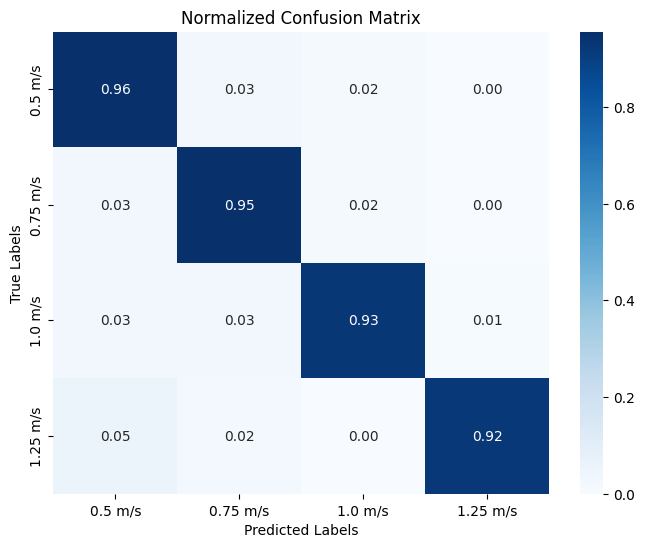

In [28]:
# conf_matrix = confusion_matrix(all_labels, all_predictions)

# class_names = ["0.5 m/s", "0.75 m/s", "1.0 m/s", "1.25 m/s"]

# conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# # Plot the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# # Add labels and title
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Normalized Confusion Matrix')
# plt.show()
